## Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
import numpy as np

# First lets load some data to run through our model
iris = load_iris()
X_train = iris['data']
y_train = iris['target'].reshape(-1,1)


scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("Classes:", np.unique(y_train))
y_train_original = y_train

X_train: (150, 4)
y_train: (150, 1)
Classes: [0 1 2]


In [3]:
def Y_transform(Y):
    m = Y.shape[0]
    Y_unique = np.unique(Y)
    Y_trans = []
    for i in range(0,3):
        yarray = np.multiply(Y==Y_unique[i],np.ones((m,1)))
        Y_trans.append(yarray.reshape(-1))
    Y_transform =  np.array(Y_trans).T
    return Y_transform

In [4]:
y_train = Y_transform(y_train)
y_train.shape

(150, 3)

In [5]:
y_train

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0

## Inistialize parameters

In [6]:
def init_params(n_inputs, hidden_dims, output_dims=1, init_scale=0.05):
    """
    Dynamically generate randomly initialized parameters for model based on user inputs.
    Arguments:
        n_inputs (int): number of inputs features
        hidden_dims (list): number of neurons (integers) in each hidden layer
        output_dims (int): number of output neurons in layer L
        init_scale (float): scaling factor for random initialization 
    Returns:
        parameters (dictionary): a dictionary of weight and bias parameters for each layer.
    """
    layer_dims = [n_inputs]+hidden_dims+[output_dims]
    L = len(layer_dims)
    
    parameters = {}
    for l in range(1,L):
        parameters['W'+str(l)] = np.random.randn(layer_dims[l-1],layer_dims[l])*init_scale
        parameters['b'+str(l)] = np.zeros((1,layer_dims[l]))
    
    return parameters
    

In [7]:
# Let's test it out
n_inputs = X_train.shape[1] # Extract number of inputs from training dat a
hidden_layers = [32, 64] # Layer 1 will have 32 neurons, Layer 2 two wil l have 32 neurons
n_outputs = 3
parameters = init_params(n_inputs,hidden_layers,n_outputs)
for key, value in parameters.items():
    print(key,value.shape)

W1 (4, 32)
b1 (1, 32)
W2 (32, 64)
b2 (1, 64)
W3 (64, 3)
b3 (1, 3)


## Forward Model

In [7]:
#define functions

def sigmoid(z):
    return 1 / (1 + np.exp(-z))
def relu(z):
    return np.maximum(0, z)
def softmax(z):
    m = z.shape[1]
    n = z.shape[0]
    sm = np.zeros((z.shape))
    maxvals = np.reshape(np.amax(z,1),(-1,n)).T.dot(np.ones((1,m)))
    exps = np.exp(z - maxvals)    
    expsums = np.sum(exps,axis=1)
    for i in range(0,m): 
        sm[:,i] = np.divide(exps[:,i],expsums)
    return sm

In [8]:
np.array([[3],[4],[5]]).dot(np.array([[1,1,1]]))
A = np.array([1,2,3])
B = np.array([[1,2,4],[7,2,1]])
np.reshape(np.amax(B,1),(-1,2)).T.dot(np.ones((1,3)))
np.sum(B,axis=1)

array([ 7, 10])

In [9]:
def L_model_forward(X, parameters, tanh=False, print_shapes=False):
    """
    Runs X inputs through the model layers (based on the number paramete
rs in `paremters` dictionary) for a single forward pass
    Arguments:
        X (numpy array): input data to be run through the model. Input s
ize should match `n_inputs` specified in W1 of parameters arg
        parameters (dictionary): model weights and bias vectors for each
layer
        tanh (boolean): if True, use tanh activation for hidden layers,
 else use ReLU (default)
        print_shapes (boolean): purely for demonstration purposes; if Tr
ue, print layer shapes
    Retruns:
        A (numpy array): the final layer output for a single forward pas
s (A[L])
        caches (tuple): cached layer outputs (used for backprop) in the
 form of ((A_prev, W, b), Z)
    """
    L = len(parameters)//2
    A = X
    caches = []
    
    for l in range(1,L+1):
        W = parameters['W'+str(l)] #read current weights
        b = parameters['b'+str(l)]
        A_prev = A                 #read previous A matrix
        Z = A_prev.dot(W)+b        #current Z
        
        if print_shapes:
            print("A[{}] shape:".format(l), A_prev.shape) 
            print("W[{}] shape:".format(l), W.shape) 
            print("Z[{}] shape:".format(l), Z.shape)
        
        if l == L:
            A = softmax(Z)
        else:
            if tanh:
                A = np.tanh(Z)
            else:
                A = relu(Z)
        
        cache = ((A_prev, W, b), Z)
        caches.append(cache)
        
    return A, caches
        
        

In [10]:
# Let's test it out
n_inputs = X_train.shape[1] # Extract number of inputs from training data
hidden_layers = [32, 64] # Layer 1 will have 32 neurons, Layer 2 two wil l have 64 neurons
n_outputs = 3

parameters = init_params(n_inputs,hidden_layers,n_outputs)
# parameters = update_parameters(parameters,grads,0.01)
AL, caches = L_model_forward(X_train,parameters,print_shapes=True) 

(a1,w2,b2), z2= caches[1]
w2.shape

A[1] shape: (150, 4)
W[1] shape: (4, 32)
Z[1] shape: (150, 32)
A[2] shape: (150, 32)
W[2] shape: (32, 64)
Z[2] shape: (150, 64)
A[3] shape: (150, 64)
W[3] shape: (64, 3)
Z[3] shape: (150, 3)


(32, 64)

## Cost

In [11]:
def compute_cost(AL, Y):
    """
    Computes the binary crossentropy loss
    Arguments:
        AL (numpy array): output of the last layer of the model (each el
ement of array is sigmoid output between 0 and 1)
        Y (numpy array): true Y values (0 or 1), should be same shape AL
    Returns:
        cost (float): the average loss over m instances
    """
    
    m = Y.shape[0]
    
    cost = -(1/m)*np.sum(np.multiply(Y,np.log(AL)))
    return cost


In [12]:
# Let's test it out
# Calculate cost
cost = compute_cost(AL,y_train)
cost

1.0975392944192448

## Backward Model

In [13]:
# def softmax_backward(dA, cache):
#     """Calculate gradients of loss with respect to Z""" 
#     z = cache
#     m = z.shape[1]
#     sm_d = np.zeros((z.shape))
#     exps = np.exp(z)
#     expsums = np.sum(exps,axis=1)
# #     print(exxps)
#     for i in range(0,m): 
#         s = np.divide(exps[:,i],exps[:,i]+expsums-exps[:,i])
#         sm_d[:,i] = np.multiply(s,1-s)
#     dz = np.multiply(dA,sm_d)
#     return dz
def softmax_backward(dA, cache):
    """Calculate gradients of loss with respect to Z""" 
    z = cache
    n = z.shape[1]
    s = softmax(z)
    sm_d = np.zeros((z.shape))
    for i in range(0,n):
        s_in = s[:,i]
        s_ex = np.delete(s,i,1)
        dA_in = dA[:,i]
        dA_ex = np.delete(dA,i,1)
        dz_different = np.zeros((z.shape[0],z.shape[1]-1))
        dz_same = np.multiply(s_in,1-s_in)
        dz_different[:,0] = np.multiply(s_ex[:,0],-s_in)
        dz_different[:,1] = np.multiply(s_ex[:,1],-s_in)
#         print(dz_different.shape)
        sm_d[:,i] = np.multiply(dA_in,dz_same)+np.multiply(dA_ex[:,0],dz_different[:,0])+np.multiply(dA_ex[:,1],dz_different[:,1])
    return sm_d
def tanh_backward(dA, cache):
    """Calculate gradients of loss with respect to Z"""
    Z = cache
    dZ = dA.T * (1 - np.tanh(Z)**2) # Multiply by dA (chain rule) return dZ
    return dZ

def relu_backward(dA, cache):
    """Calculate gradients of loss with respect to Z"""
    Z = cache
    dZ = np.array(dA.T, copy=True) # Multiply by dA (chain rule) dZ[Z <= 0] = 0
    return dZ

In [14]:
def L_model_backward(AL,Y,caches,tanh=True):
    grads = {}
    L = len(caches) # number of layers
    m = AL.shape[0] # number of observers
    
    (A_prev, W, b), Z = caches[-1]
    
    dAL = -np.divide(Y,AL) # partial J/partial A
    dZ = softmax_backward(dAL,Z) #partial J/partial Z
    
    dW = (1./m)*np.dot(dZ.T, A_prev) # partial J/partial W
    db = (1./m)*np.sum(dZ.T, axis=1, keepdims=True) # partial J/partial b
    
    dA_prev = np.dot(W, dZ.T)
    
    grads['dW'+str(L)] = dW
    grads['db'+str(L)] = db
    
    for l in reversed(range(1,L)):
        (A_prev, W, b), Z = caches[l-1]
        if tanh:
            dZ = tanh_backward(dA_prev,Z)
        else:
            dZ = relu_backward(dA_prev,Z)
        dW = (1. / m) * np.dot(dZ.T, A_prev)
        db = (1. / m) * np.sum(dZ.T, axis=1, keepdims=True) # Calculate dA_prev for layer L-1
        dA_prev = np.dot(W, dZ.T)
        # Store gradients
        grads["dW" + str(l)] = dW
        grads["db" + str(l)] = db
        
    return grads
    


In [15]:
grads = L_model_backward(AL, y_train, caches, tanh=True)

In [16]:
grads['db1'].shape

(32, 1)

## Update params

In [17]:
def update_parameters(parameters, grads, learning_rate):
    """
    Updates parameters W/b with gradients dW/db for each layer, to compl
ete a step of backpropagation
    Arguments:
        parameters (dictionary): model weights and bias vectors for each
layer
        grads (dictionary): parameter gradients (output of `L_model_back
ward` function)
        learning_rate (float): learning rate for gradient descent step
    Returns:
        parameters (dictionary): updated weight and bias parameters
    """
    L = len(parameters) // 2 # number of layers in the neural network # Update rule for each parameter; loop through each layer
    for l in range(1, L+1):
        parameters["W" + str(l)] = parameters["W" + str(l)] - learning_rate * grads["dW" + str(l)].T # Tranpose to match weight shape
        parameters["b" + str(l)] = parameters["b" + str(l)] - learning_rate * grads["db" + str(l)].T # Tranpose to match weight shape
    return parameters

In [18]:
parameters = update_parameters(parameters,grads,0.01)

Epoch: 0 	Cost: 1.0984875263160834


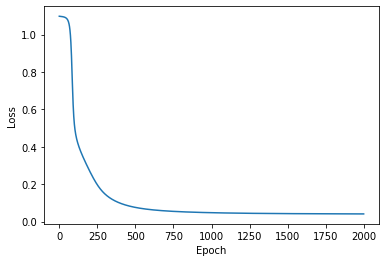

In [24]:
from sklearn.metrics import accuracy_score

# Set parameters
n_inputs = X_train.shape[1]
n_outputs = 3
hidden_layers = [32,64] # 2 layers, each with 32 neurons
init_scale = 0.02
learning_rate = 0.1
tanh = True

# Randomly initialize params
parameters = init_params(n_inputs,hidden_layers, n_outputs, init_scale=init_scale)

# Run model
n_epochs =2000
losses = []
for epoch in range(n_epochs):
    # Run forward propogation
    AL, caches = L_model_forward(X_train, parameters, tanh=tanh)
    
    # Compute cost/accuracy; print after 2000 epochs
    loss = compute_cost(AL, y_train)
    losses.append(loss)
#     if epoch % (n_epochs//10) == 0:
    if epoch % 2000 == 0:
#         y_hat = np.where(AL>0.5,1,0).reshape(-1)
        print("Epoch:",epoch, "\tCost:", loss)

    # Run backward popogation and update parameters
    grads = L_model_backward(AL, y_train, caches, tanh=tanh)
    parameters = update_parameters(parameters, grads, learning_rate)

plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()
AL, caches = L_model_forward(X_train, parameters, tanh=tanh)

In [25]:
AL.shape
AL_max_index = np.argmax(AL, axis=1)
AL_max_index
accuracy_score(y_train_original,AL_max_index)

0.9866666666666667

In [26]:
A = np.array([[1,2,3],[4,5,6]])
a_del = np.delete(A, 1, 1)
a_del

array([[1, 3],
       [4, 6]])

In [29]:
len(parameters)//2

3